# MobileNetV3 (Small) Trained on CIFAR-10


In [49]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib
# %load_ext pycodestyle_magic
# %flake8_on --ignore W291,W293,E703,E402,E999 --max_line_length=100
%load_ext jupyter_black
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch            : 2.0.1+cu118
pytorch_lightning: 2.0.6
torchmetrics     : 1.0.1
matplotlib       : 3.7.2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [50]:
import time, sys, os
import torch
from hiq.vis import print_model
import numpy as np
import torchvision
import pytorch_lightning as pl
import torchmetrics
from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

## General settings and hyperparameters


-   Here, we specify some general hyperparameter values and general settings.


In [51]:
BATCH_SIZE = 256
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 1

-   Note that using multiple workers can sometimes cause issues with too many open files in PyTorch for small datasets. If we have problems with the data loader later, try setting `NUM_WORKERS = 0` and reload the notebook.


## Implementing a Neural Network using PyTorch Lightning's `LightningModule`


-   In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
-   In essence, `LightningModule` is a wrapper around a PyTorch module.
-   We start with defining our neural network model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.
-   Here, for the PyTorch model, we are using an implementation from the Torchvision hub:

In this case, since Torchvision already offers a nice and efficient PyTorch implementation of MobileNet-v3, let's load it from the Torchvision hub:


In [52]:
pytorch_model = torch.hub.load(
    "pytorch/vision:v0.11.0", "mobilenet_v3_small", weights=None
)
print_model(pytorch_model)

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.11.0


🌳 MobileNetV3<all params:2542856>
├── Sequential(features)
│   ├── Conv2dNormActivation(0)
│   │   ├── Conv2d(0)|weight[16,3,3,3]
│   │   └── BatchNorm2d(1)|weight[16]|bias[16]
│   ├── InvertedResidual(1)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[16,1,3,3]
│   │       │   └── BatchNorm2d(1)|weight[16]|bias[16]
│   │       ├── SqueezeExcitation(1)
│   │       │   ├── Conv2d(fc1)|weight[8,16,1,1]|bias[8]
│   │       │   └── Conv2d(fc2)|weight[16,8,1,1]|bias[16]
│   │       └── Conv2dNormActivation(2)
│   │           ├── Conv2d(0)|weight[16,16,1,1]
│   │           └── BatchNorm2d(1)|weight[16]|bias[16]
│   ├── InvertedResidual(2)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[72,16,1,1]
│   │       │   └── BatchNorm2d(1)|weight[72]|bias[72]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[72,1,3,3]
│   │       │   └── BatchNorm2d(1)|weight[72]|bias[72]
│   │       └── Conv2dNormActivation(2)
│   │           ├── Conv2d(0)|weight[24,72,1,1]
│   │           └── BatchNorm2d(1)|weight[24]|bias[24]
│   ├── InvertedResidual(3)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[88,24,1,1]
│   │       │   └── BatchNorm2d(1)|weight[88]|bias[88]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[88,1,3,3]
│   │       │   └── BatchNorm2d(1)|weight[88]|bias[88]
│   │       └── Conv2dNormActivation(2)
│   │           ├── Conv2d(0)|weight[24,88,1,1]
│   │           └── BatchNorm2d(1)|weight[24]|bias[24]
│   ├── InvertedResidual(4)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[96,24,1,1]
│   │       │   └── BatchNorm2d(1)|weight[96]|bias[96]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[96,1,5,5]
│   │       │   └── BatchNorm2d(1)|weight[96]|bias[96]
│   │       ├── SqueezeExcitation(2)
│   │       │   ├── Conv2d(fc1)|weight[24,96,1,1]|bias[24]
│   │       │   └── Conv2d(fc2)|weight[96,24,1,1]|bias[96]
│   │       └── Conv2dNormActivation(3)
│   │           ├── Conv2d(0)|weight[40,96,1,1]
│   │           └── BatchNorm2d(1)|weight[40]|bias[40]
│   ├── 💠 ]8;id=431802;/home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/torchvision/models/mobilenetv3.py\InvertedResidual]8;;\]8;id=177845;/home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/torchvision/models/mobilenetv3.py\(5-6)<🦜:57264x2>]8;;\
│   │   ┗━━ Sequential(block)
│   │       ┣━━ Conv2dNormActivation(0)
│   │       ┃   ┣━━ Conv2d(0)|weight[240,40,1,1]
│   │       ┃   ┗━━ BatchNorm2d(1)|weight[240]|bias[240]
│   │       ┣━━ Conv2dNormActivation(1)
│   │       ┃   ┣━━ Conv2d(0)|weight[240,1,5,5]
│   │       ┃   ┗━━ BatchNorm2d(1)|weight[240]|bias[240]
│   │       ┣━━ SqueezeExcitation(2)
│   │       ┃   ┣━━ Conv2d(fc1)|weight[64,240,1,1]|bias[64]
│   │       ┃   ┗━━ Conv2d(fc2)|weight[240,64,1,1]|bias[240]
│   │       ┗━━ Conv2dNormActivation(3)
│   │           ┣━━ Conv2d(0)|weight[40,240,1,1]
│   │           ┗━━ BatchNorm2d(1)|weight[40]|bias[40]
│   ├── InvertedResidual(7)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[120,40,1,1]
│   │       │   └── BatchNorm2d(1)|weight[120]|bias[120]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[120,1,5,5]
│   │       │   └── BatchNorm2d(1)|weight[120]|bias[120]
│   │       ├── SqueezeExcitation(2)
│   │       │   ├── Conv2d(fc1)|weight[32,120,1,1]|bias[32]
│   │       │   └── Conv2d(fc2)|weight[120,32,1,1]|bias[120]
│   │       └── Conv2dNormActivation(3)
│   │           ├── Conv2d(0)|weight[48,120,1,1]
│   │           └── BatchNorm2d(1)|weight[48]|bias[48]
│   ├── InvertedResidual(8)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[144,48,1,1]
│   │       │   └

-   Since the Torchvision model above was implemented for ImageNet, which has a different number of classes than CIFAR-10, we define our own output layer below:


In [53]:
pytorch_model.classifier[-1] = torch.nn.Linear(in_features=1024, out_features=10)
print_model(pytorch_model)

🌳 MobileNetV3<all params:1528106>
├── Sequential(features)
│   ├── Conv2dNormActivation(0)
│   │   ├── Conv2d(0)|weight[16,3,3,3]
│   │   └── BatchNorm2d(1)|weight[16]|bias[16]
│   ├── InvertedResidual(1)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[16,1,3,3]
│   │       │   └── BatchNorm2d(1)|weight[16]|bias[16]
│   │       ├── SqueezeExcitation(1)
│   │       │   ├── Conv2d(fc1)|weight[8,16,1,1]|bias[8]
│   │       │   └── Conv2d(fc2)|weight[16,8,1,1]|bias[16]
│   │       └── Conv2dNormActivation(2)
│   │           ├── Conv2d(0)|weight[16,16,1,1]
│   │           └── BatchNorm2d(1)|weight[16]|bias[16]
│   ├── InvertedResidual(2)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[72,16,1,1]
│   │       │   └── BatchNorm2d(1)|weight[72]|bias[72]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[72,1,3,3]
│   │       │   └── BatchNorm2d(1)|weight[72]|bias[72]
│   │       └── Conv2dNormActivation(2)
│   │           ├── Conv2d(0)|weight[24,72,1,1]
│   │           └── BatchNorm2d(1)|weight[24]|bias[24]
│   ├── InvertedResidual(3)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[88,24,1,1]
│   │       │   └── BatchNorm2d(1)|weight[88]|bias[88]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[88,1,3,3]
│   │       │   └── BatchNorm2d(1)|weight[88]|bias[88]
│   │       └── Conv2dNormActivation(2)
│   │           ├── Conv2d(0)|weight[24,88,1,1]
│   │           └── BatchNorm2d(1)|weight[24]|bias[24]
│   ├── InvertedResidual(4)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[96,24,1,1]
│   │       │   └── BatchNorm2d(1)|weight[96]|bias[96]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[96,1,5,5]
│   │       │   └── BatchNorm2d(1)|weight[96]|bias[96]
│   │       ├── SqueezeExcitation(2)
│   │       │   ├── Conv2d(fc1)|weight[24,96,1,1]|bias[24]
│   │       │   └── Conv2d(fc2)|weight[96,24,1,1]|bias[96]
│   │       └── Conv2dNormActivation(3)
│   │           ├── Conv2d(0)|weight[40,96,1,1]
│   │           └── BatchNorm2d(1)|weight[40]|bias[40]
│   ├── 💠 ]8;id=899743;/home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/torchvision/models/mobilenetv3.py\InvertedResidual]8;;\]8;id=892816;/home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/torchvision/models/mobilenetv3.py\(5-6)<🦜:57264x2>]8;;\
│   │   ┗━━ Sequential(block)
│   │       ┣━━ Conv2dNormActivation(0)
│   │       ┃   ┣━━ Conv2d(0)|weight[240,40,1,1]
│   │       ┃   ┗━━ BatchNorm2d(1)|weight[240]|bias[240]
│   │       ┣━━ Conv2dNormActivation(1)
│   │       ┃   ┣━━ Conv2d(0)|weight[240,1,5,5]
│   │       ┃   ┗━━ BatchNorm2d(1)|weight[240]|bias[240]
│   │       ┣━━ SqueezeExcitation(2)
│   │       ┃   ┣━━ Conv2d(fc1)|weight[64,240,1,1]|bias[64]
│   │       ┃   ┗━━ Conv2d(fc2)|weight[240,64,1,1]|bias[240]
│   │       ┗━━ Conv2dNormActivation(3)
│   │           ┣━━ Conv2d(0)|weight[40,240,1,1]
│   │           ┗━━ BatchNorm2d(1)|weight[40]|bias[40]
│   ├── InvertedResidual(7)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[120,40,1,1]
│   │       │   └── BatchNorm2d(1)|weight[120]|bias[120]
│   │       ├── Conv2dNormActivation(1)
│   │       │   ├── Conv2d(0)|weight[120,1,5,5]
│   │       │   └── BatchNorm2d(1)|weight[120]|bias[120]
│   │       ├── SqueezeExcitation(2)
│   │       │   ├── Conv2d(fc1)|weight[32,120,1,1]|bias[32]
│   │       │   └── Conv2d(fc2)|weight[120,32,1,1]|bias[120]
│   │       └── Conv2dNormActivation(3)
│   │           ├── Conv2d(0)|weight[48,120,1,1]
│   │           └── BatchNorm2d(1)|weight[48]|bias[48]
│   ├── InvertedResidual(8)
│   │   └── Sequential(block)
│   │       ├── Conv2dNormActivation(0)
│   │       │   ├── Conv2d(0)|weight[144,48,1,1]
│   │       │   └

-   Next, we can define our LightningModule as a wrapper around our PyTorch model:


In [54]:
# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model
        if hasattr(model, "dropout_proba"):
            self.dropout_proba = model.dropout_proba
        # Save settings and hyperparameters to the log directory but skip the model parameters
        self.save_hyperparameters(ignore=["model"])
        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        # Do another forward pass in .eval() mode to compute accuracy
        # while accountingfor Dropout, BatchNorm etc. behavior
        # during evaluation (inference)
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log(
            "valid_acc",
            self.valid_acc,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Setting up the dataset


-   In this section, we are going to set up our dataset.


### Inspecting the dataset


In [55]:
train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=True,
    shuffle=True,
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=transforms.ToTensor()
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False,
    shuffle=False,
)

Files already downloaded and verified


In [56]:
train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTraining label distribution:")
sorted(train_counter.items())

print("*" * 80)
print("\nTest label distribution:")
sorted(test_counter.items())


Training label distribution:
********************************************************************************

Test label distribution:


[(0, 1000),
 (1, 1000),
 (2, 1000),
 (3, 1000),
 (4, 1000),
 (5, 1000),
 (6, 1000),
 (7, 1000),
 (8, 1000),
 (9, 1000)]

### Performance baseline


-   Especially for imbalanced datasets, it's pretty helpful to compute a performance baseline.
-   In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- we want our model to be better than that!


In [57]:
# %load ../code_dataset/performance_baseline.py
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 3
Accuracy when always predicting the majority class:
0.10 (10.00%)


## A quick visual check


256


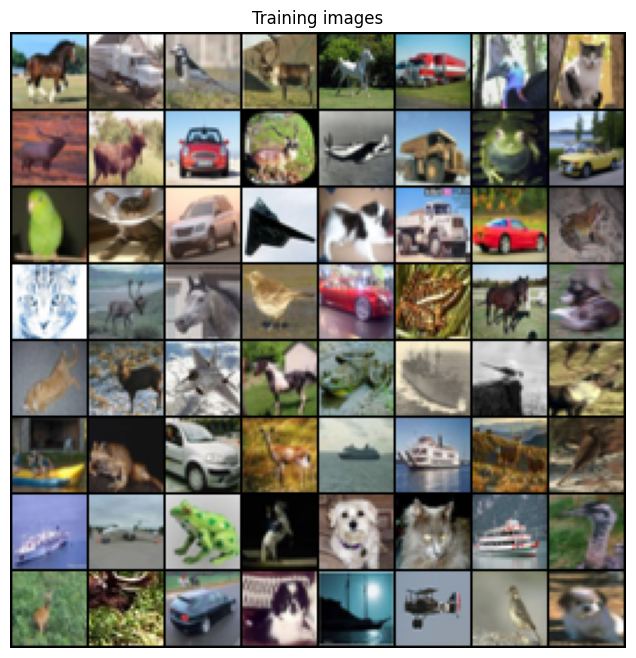

In [58]:
for images, labels in train_loader:
    break

num_images_in_first_batch = len(images)
print(num_images_in_first_batch)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(images[64 : 64 + 64], padding=1, normalize=True),
        (1, 2, 0),
    )
)
plt.show()

### Setting up a `DataModule`


-   There are three main ways we can prepare the dataset for Lightning. We can
    1. make the dataset part of the model;
    2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the following subsection;
    3. create a LightningDataModule.
-   Here, we will use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods, as we can see below:


In [59]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)
        self.train_transform = transforms.Compose(
            [
                transforms.Resize((70, 70)),
                transforms.RandomCrop((64, 64)),
                transforms.ToTensor(),
            ]
        )
        self.test_transform = transforms.Compose(
            [
                transforms.Resize((70, 70)),
                transforms.CenterCrop((64, 64)),
                transforms.ToTensor(),
            ]
        )

    def setup(self, stage=None):
        train = datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )
        self.test = datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False,
        )
        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return test_loader

-   Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the dataset loading -- if we run our code in a distributed setting, this will be called on each node / GPU.
-   Next, let's initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):


In [60]:
torch.manual_seed(1)
data_module = DataModule(data_path="./data")

## Training the model using the PyTorch Lightning Trainer class


-   Next, we initialize our model.
-   Also, we define a call back to obtain the model with the best validation set performance after training.
-   PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. However, here, we will keep things simple and use the `CSVLogger`:


In [61]:
lightning_model = LightningModel(pytorch_model, learning_rate=LEARNING_RATE)
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc")  # save top 1 model
]
logger = CSVLogger(save_dir="logs/", name="mv3-cifar10")

-   Now it's time to train our model:


In [62]:
# %load ../code_lightningmodule/trainer_nb_basic.py
torch.set_float32_matmul_precision("high")
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=False,
    log_every_n_steps=10,
)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)
runtime = (time.time() - start_time) / 60
print(f"Training took {runtime:.2f} min in total.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2


Files already downloaded and verified


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 )                                                                                           │
│   12                                                                                             │
│   13 start_time = time.time()                                                                    │
│ ❱ 14 trainer.fit(model=lightning_model, datamodule=data_module)                                  │
│   15 runtime = (time.time() - start_time) / 60                                                   │
│   16 print(f"Training took {runtime:.2f} min in total.")                                         │
│   17                                                                                             │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.p │
│ y:529 in fit                                                                                     │
│                                                                                                  │
│    526 │   │   """                                                                               │
│    527 │   │   model = _maybe_unwrap_optimized(model)                                            │
│    528 │   │   self.strategy._lightning_module = model                                           │
│ ❱  529 │   │   call._call_and_handle_interrupt(                                                  │
│    530 │   │   │   self, self._fit_impl, model, train_dataloaders, val_dataloaders, datamodule,  │
│    531 │   │   )                                                                                 │
│    532                                                                                           │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:4 │
│ 1 in _call_and_handle_interrupt                                                                  │
│                                                                                                  │
│    38 │   """                                                                                    │
│    39 │   try:                                                                                   │
│    40 │   │   if trainer.strategy.launcher is not None:                                          │
│ ❱  41 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│    42 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    43 │                                                                                          │
│    44 │   except _TunerExitException:                                                            │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/strategies/launch │
│ ers/multiprocessing.py:124 in launch                                                             │
│                                                                                                  │
│   121 │   │   │   join=False,  # we will join ourselves to get the process references            │
│   122 │   │   )                                                                                  │
│   123 │   │   self.procs = process_context.processes                                             │
│ ❱ 124 │   │   while not process_context.join():            

## Evaluating the model


-   After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (PS: you may want to check out [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) later on, which take care of it for us):


In [63]:
# %load ../code_lightningmodule/logger_csv_plot_basic.py


fname = f"{trainer.logger.log_dir}/metrics.csv"
print(fname)
metrics = pd.read_csv(fname)

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

logs/mv3-cifar10/version_2/metrics.csv


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│    3                                                                                             │
│    4 fname = f"{trainer.logger.log_dir}/metrics.csv"                                             │
│    5 print(fname)                                                                                │
│ ❱  6 metrics = pd.read_csv(fname)                                                                │
│    7                                                                                             │
│    8 aggreg_metrics = []                                                                         │
│    9 agg_col = "epoch"                                                                           │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pandas/io/parsers/readers.py:912 in │
│ read_csv                                                                                         │
│                                                                                                  │
│    909 │   )                                                                                     │
│    910 │   kwds.update(kwds_defaults)                                                            │
│    911 │                                                                                         │
│ ❱  912 │   return _read(filepath_or_buffer, kwds)                                                │
│    913                                                                                           │
│    914                                                                                           │
│    915 # iterator=True -> TextFileReader                                                         │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pandas/io/parsers/readers.py:577 in │
│ _read                                                                                            │
│                                                                                                  │
│    574 │   _validate_names(kwds.get("names", None))                                              │
│    575 │                                                                                         │
│    576 │   # Create the parser.                                                                  │
│ ❱  577 │   parser = TextFileReader(filepath_or_buffer, **kwds)                                   │
│    578 │                                                                                         │
│    579 │   if chunksize or iterator:                                                             │
│    580 │   │   return parser                                                                     │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pandas/io/parsers/readers.py:1407   │
│ in __init__                                                                                      │
│                                                                                                  │
│   1404 │   │   │   self.options["has_index_names"] = kwds["has_index_names"]                     │
│   1405 │   │                                                                                     │
│   1406 │   │   self.handles: IOHandles | None = None                                             │
│ ❱ 1407 │   │   self._engine = self._make_engine(f, self.eng

-   The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:


In [64]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path="best")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.test(model=lightning_model, datamodule=data_module, ckpt_path="best")                │
│   2                                                                                              │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.p │
│ y:735 in test                                                                                    │
│                                                                                                  │
│    732 │   │   else:                                                                             │
│    733 │   │   │   model = _maybe_unwrap_optimized(model)                                        │
│    734 │   │   │   self.strategy._lightning_module = model                                       │
│ ❱  735 │   │   return call._call_and_handle_interrupt(                                           │
│    736 │   │   │   self, self._test_impl, model, dataloaders, ckpt_path, verbose, datamodule     │
│    737 │   │   )                                                                                 │
│    738                                                                                           │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:4 │
│ 1 in _call_and_handle_interrupt                                                                  │
│                                                                                                  │
│    38 │   """                                                                                    │
│    39 │   try:                                                                                   │
│    40 │   │   if trainer.strategy.launcher is not None:                                          │
│ ❱  41 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│    42 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    43 │                                                                                          │
│    44 │   except _TunerExitException:                                                            │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/strategies/launch │
│ ers/multiprocessing.py:124 in launch                                                             │
│                                                                                                  │
│   121 │   │   │   join=False,  # we will join ourselves to get the process references            │
│   122 │   │   )                                                                                  │
│   123 │   │   self.procs = process_context.processes                                             │
│ ❱ 124 │   │   while not process_context.join():                                                  │
│   125 │   │   │   pass                                                                           │
│   126 │   │                                                                                      │
│   127 │   │   worker_output = return_queue.get()                                                 │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-package

## Predicting labels of new data


-   We can use the `trainer.predict` method either on a new `DataLoader` (`trainer.predict(dataloaders=...)`) or `DataModule` (`trainer.predict(datamodule=...)`) to apply the model to new data.
-   Alternatively, we can also manually load the best model from a checkpoint as shown below:


In [65]:
path = trainer.checkpoint_callback.best_model_path
print(path)

In [66]:
lightning_model = LightningModel.load_from_checkpoint(path, model=pytorch_model)
lightning_model = lightning_model.to("cuda")
lightning_model.eval();

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 lightning_model = LightningModel.load_from_checkpoint(path, model=pytorch_model)             │
│   2 lightning_model = lightning_model.to("cuda")                                                 │
│   3 lightning_model.eval();                                                                      │
│   4                                                                                              │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/module.py:15 │
│ 20 in load_from_checkpoint                                                                       │
│                                                                                                  │
│   1517 │   │   │   pretrained_model.freeze()                                                     │
│   1518 │   │   │   y_hat = pretrained_model(x)                                                   │
│   1519 │   │   """                                                                               │
│ ❱ 1520 │   │   loaded = _load_from_checkpoint(                                                   │
│   1521 │   │   │   cls,                                                                          │
│   1522 │   │   │   checkpoint_path,                                                              │
│   1523 │   │   │   map_location,                                                                 │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:62 │
│ in _load_from_checkpoint                                                                         │
│                                                                                                  │
│    59 │   **kwargs: Any,                                                                         │
│    60 ) -> Union["pl.LightningModule", "pl.LightningDataModule"]:                                │
│    61 │   with pl_legacy_patch():                                                                │
│ ❱  62 │   │   checkpoint = pl_load(checkpoint_path, map_location=map_location)                   │
│    63 │                                                                                          │
│    64 │   # convert legacy checkpoints to the new format                                         │
│    65 │   checkpoint = _pl_migrate_checkpoint(                                                   │
│                                                                                                  │
│ /home/ubuntu/miniconda3/envs/ocr/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io │
│ .py:50 in _load                                                                                  │
│                                                                                                  │
│   47 │   │   │   map_location=map_location,  # type: ignore[arg-type]                            │
│   48 │   │   )                                                                                   │
│   49 │   fs = get_filesystem(path_or_url)                                                        │
│ ❱ 50 │   with fs.open(path_or_url, "rb") as f:                                                   │
│   51 │   │   return torch.load(f, map_location=map_location)  # type: ignore[arg-type]           │
│   52                                                                                             │
│   53                                                       

-   For simplicity, we reused our existing `pytorch_model` above. However, we could also reinitialize the `pytorch_model`, and the `.load_from_checkpoint` method would load the corresponding model weights for us from the checkpoint file.
-   Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.


In [67]:
# %load ../code_lightningmodule/datamodule_testloader.py
test_dataloader = data_module.test_dataloader()
device = "cuda" if torch.cuda.is_available() else "cpu"
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

for batch in test_dataloader:
    features, true_labels = batch
    features = features.to("cuda")
    true_labels = true_labels.to(device)

    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, true_labels)

predicted_labels[:5]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 # %load ../code_lightningmodule/datamodule_testloader.py                                    │
│ ❱  2 test_dataloader = data_module.test_dataloader()                                             │
│    3 device = "cuda" if torch.cuda.is_available() else "cpu"                                     │
│    4 acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)                   │
│    5                                                                                             │
│                                                                                                  │
│ in test_dataloader:60                                                                            │
│                                                                                                  │
│   57 │                                                                                           │
│   58 │   def test_dataloader(self):                                                              │
│   59 │   │   test_loader = DataLoader(                                                           │
│ ❱ 60 │   │   │   dataset=self.test,                                                              │
│   61 │   │   │   batch_size=BATCH_SIZE,                                                          │
│   62 │   │   │   drop_last=False,                                                                │
│   63 │   │   │   shuffle=False,                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DataModule' object has no attribute 'test'

-   As an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.


In [68]:
test_acc = acc.compute()
print(f"Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 test_acc = acc.compute()                                                                     │
│   2 print(f"Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")                                │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'acc' is not defined

## Inspecting Failure Cases


-   In practice, it is often informative to look at failure cases like wrong predictions for particular training instances as it can give us some insights into the model behavior and dataset.
-   Inspecting failure cases can sometimes reveal interesting patterns and even highlight dataset and labeling issues.


In [69]:
class_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [70]:
sys.path.append("../../pytorch_ipynb")
from helper_plotting import show_examples

show_examples(model=lightning_model, data_loader=test_dataloader, class_dict=class_dict)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 sys.path.append("../../pytorch_ipynb")                                                       │
│   2 from helper_plotting import show_examples                                                    │
│   3                                                                                              │
│ ❱ 4 show_examples(model=lightning_model, data_loader=test_dataloader, class_dict=class_dict)     │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'test_dataloader' is not defined

-   In addition to inspecting failure cases visually, it is also informative to look at which classes the model confuses the most via a confusion matrix:


In [71]:
# %load ../code_lightningmodule/plot_confusion-matrix_basic.py
cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict)).to(device)

for x, y in test_dataloader:
    with torch.no_grad():
        pred = lightning_model(x.to(device))
    cmat(pred, y.to(device))

cmat_tensor = cmat.compute()
cmat = cmat_tensor.cpu().numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
    # normed colormaps highlight the off-diagonals
    # for high-accuracy models better
)

plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 # %load ../code_lightningmodule/plot_confusion-matrix_basic.py                              │
│ ❱  2 cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict)).to(device)           │
│    3                                                                                             │
│    4 for x, y in test_dataloader:                                                                │
│    5 │   with torch.no_grad():                                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'device' is not defined

In [72]:
%watermark --iversions

torchmetrics     : 1.0.1
pandas           : 2.0.3
pytorch_lightning: 2.0.6
rich             : 13.4.2
torchvision      : 0.15.2+cu118
torch            : 2.0.1+cu118
numpy            : 1.24.4
matplotlib       : 3.7.2
sys              : 3.8.17 (default, Jul  5 2023, 21:04:15) 
[GCC 11.2.0]

